In [1]:
import pandas as pd

from glob import glob  
from natsort import natsorted, ns

import geopy
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import rasterio  
from rasterio.plot import show
from pyproj import Transformer
from rasterio.windows import Window
import rioxarray 

import imageio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# To display interactive plot
# %matplotlib notebook
# To display static plot below the code block
%matplotlib inline

In [2]:
address = "Gramyelaan 24 2960 Brecht"
#Provide an address with the format 'street name with number', 'postcode' and city'
#address = input("Please Provide House Addres Here: ")
#address = "Rue Brogniez 158 1070 Anderlecht"

### Locate address on the map and plot it using folium

In [3]:
def get_coordinates(address: str) -> float:
        """Function to get address coordinate
            plot it on a map"""

        geolocator = Nominatim(user_agent="3D_house_app")
        location = geolocator.geocode(address)
        location.latitude, location.longitude
        location_lat_long = [location.latitude, location.longitude]
        return location_lat_long
        
def plot_address(address):
    """plot the address on a map"""
    geolocator = Nominatim(user_agent="3D_house_app")
    location = geolocator.geocode(address)
    location.latitude, location.longitude
    location_lat_long = [location.latitude, location.longitude]
    location_map = folium.Map(location=location_lat_long, zoom_start=25)
    folium.Marker(location=location_lat_long, popup=location_lat_long).add_to(location_map)
    return location_map 
plot_address(address)

In [4]:
latitude,longitude = get_coordinates(address)
latitude,longitude

(51.2887576, 4.573482668463942)

### Transform to Belgium 'EPSG:31370' coordinate

In [5]:
def transform_address(x,y):
    transformer = Transformer.from_crs("EPSG:4326", crs_to = 'EPSG:31370' ,always_xy=True)
    lat, lon = transformer.transform(longitude, latitude)
    return lat,lon

In [6]:
xx,yy = transform_address(latitude,longitude)

### Get coordinates from Belgium_houses_address.csv

In [7]:
address_csv = './House_address/Belgium_houses_address.csv'

In [8]:
index = []
df = pd.read_csv(address_csv)
for i in range(df.shape[0]):
    if df['Address'][i] == address :
        index.append(i)
        break
    continue
x = df['EPSG:31370_x'][index][index[0]]
y = df['EPSG:31370_y'][index][index[0]] 
lat = df['EPSG:4326_lat'][index][index[0]]
lon = df['EPSG:4326_lon'][index][index[0]]

### Read tiff files from specified path

In [9]:
def get_tif(path):
    #Function to get all tif files and sort them
    tif_file =[]
    files = glob(path,recursive = True) 
    for file in files: 
        tif_file.append(file)
    tif_file = natsorted(tif_file, alg=ns.IGNORECASE)
    return tif_file

In [10]:
dsm_path = './Map_files/DSM/**/*.tif'
DSM_tif = get_tif(dsm_path)
DSM_tif[:3]

['./Map_files/DSM/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif',
 './Map_files/DSM/DHMVIIDSMRAS1m_k02/GeoTIFF/DHMVIIDSMRAS1m_k02.tif',
 './Map_files/DSM/DHMVIIDSMRAS1m_k03/GeoTIFF/DHMVIIDSMRAS1m_k03.tif']

In [11]:
dtm_path = './Map_files/DTM/**/*.tif'
DTM_tif = get_tif(dtm_path)
DTM_tif[:3]

['./Map_files/DTM/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif',
 './Map_files/DTM/DHMVIIDTMRAS1m_k02/GeoTIFF/DHMVIIDTMRAS1m_k02.tif',
 './Map_files/DTM/DHMVIIDTMRAS1m_k03/GeoTIFF/DHMVIIDTMRAS1m_k03.tif']

### Get bounds from tiff files

In [12]:
tif_bounds = []
for i in DSM_tif:
    src = rasterio.open(i)
    tif_bounds.append(src.bounds)

In [13]:
tif_bounds[7], x, y ,lat, lon

(BoundingBox(left=162000.0, bottom=218000.0, right=194000.0, top=238000.0),
 164283.39,
 219897.74,
 51.28876,
 4.5735)

### Check in which tiff the address is located for DSM & DTM

In [14]:
found_DSM_path = []
found_DTM_path = []
for i,bound in enumerate(tif_bounds,1):
    if (x >= bound[0] and x <= bound[2]) & \
        (y >= bound[1] and y <= bound[3]):
        if i<=9:
            found_DSM_path.append('./Map_files/DSM/DHMVIIDSMRAS1m_k0'+ str(i) +'/GeoTIFF/DHMVIIDSMRAS1m_k0'+ str(i) + '.tif')
            found_DTM_path.append('./Map_files/DTM/DHMVIIDTMRAS1m_k0'+ str(i) +'/GeoTIFF/DHMVIIDTMRAS1m_k0'+ str(i) + '.tif')
            print('Tif location: ', 'DHMVIIDSMRAS1m_k0' + str(i) + '.tif')
        else:
            found_DSM_path.append('./Map_files/DSM/DHMVIIDSMRAS1m_k'+ str(i) +'/GeoTIFF/DHMVIIDSMRAS1m_k'+ str(i) + '.tif')
            found_DTM_path.append('./Map_files/DTM/DHMVIIDTMRAS1m_k'+ str(i) +'/GeoTIFF/DHMVIIDTMRAS1m_k'+ str(i) + '.tif')
            print('Tif location: ', 'DHMVIIDSMRAS1m_k' + str(i) + '.tif')
    else:None

Tif location:  DHMVIIDSMRAS1m_k08.tif


### Read the found tiff in to rasterio df

In [17]:
rast_dsm_df = rioxarray.open_rasterio(found_DSM_path[0],masked=True,chunks=True)

In [18]:
rast_dtm_df = rioxarray.open_rasterio(found_DTM_path[0],masked=True,chunks=True)

### Set window size and get geometries

In [19]:
n = 17
left,bottom = [(x-n),(y+n)],[(x+n),(y+n)]
right,top = [(x+n),(y-n)] ,[(x-n),(y-n)]
geometries = [ {'type': 'Polygon', 'coordinates': [[left,bottom, right,top,left]]}]

### Clip DSM and DTM

In [20]:
clipped_dsm = rast_dsm_df.rio.clip(geometries)

In [21]:
clipped_dtm = rast_dtm_df.rio.clip(geometries)

### Plot clipped DSM & DTM

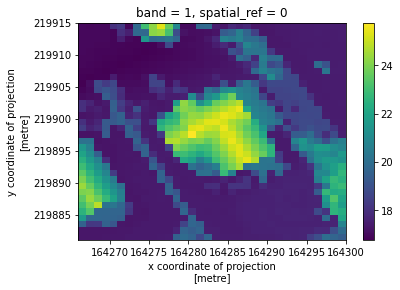

In [22]:
clipped_dsm.plot()

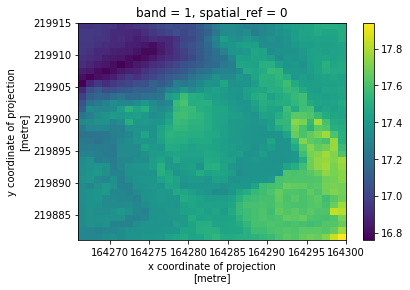

In [23]:
clipped_dtm.plot()

### Save clipped DSM & DTM

In [24]:
clipped_dsm.rio.to_raster(address +"_dsm.tif",tiled=True, dtype="int32")

In [25]:
clipped_dtm.rio.to_raster(address +"_dtm.tif",tiled=True, dtype="int32")

### Read saved tif files using imageio

In [26]:
img_dsm= imageio.imread(address +"_dsm.tif")

In [27]:
img_dtm = imageio.imread(address +"_dtm.tif")

### Plot clipped DSM tif using matplotlib

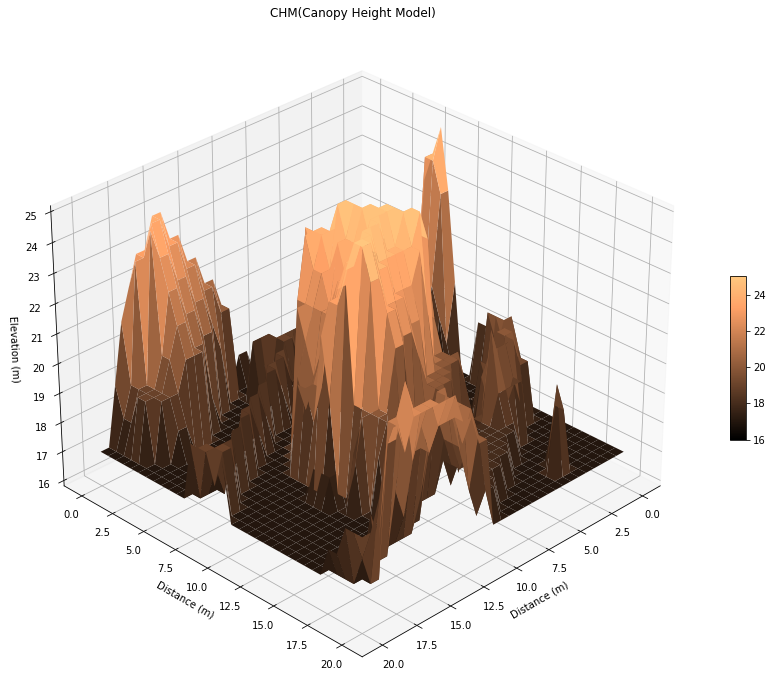

In [28]:
nx,ny = img_dsm.shape
size=10
x = np.linspace(0, size*2, nx)
y = np.linspace(0, size*2, ny)
ym,xm = np.meshgrid(x, y)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
chm3ddsm=ax.plot_surface(xm,ym,img_dsm,cmap='copper',linewidth=0)
ax.set_title('CHM(Canopy Height Model)')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Distance (m)')
ax.set_zlabel('Elevation (m)')
ax.view_init(azim=45)
fig.colorbar(chm3ddsm, shrink=0.2, aspect=10)
plt.show()

### Calculate CHM (Canopy height)

In [29]:
with rasterio.open(address +"_dsm.tif") as src:
    lidar_dsm_im = src.read(1, masked=True)
    dtm_meta = src.profile

with rasterio.open(address +"_dtm.tif") as src:
    lidar_dtm_im = src.read(1, masked=True)
    dsm_meta = src.profile
    
lidar_chm = lidar_dsm_im - lidar_dtm_im
    
with rasterio.open(address +'_chm.tif', 'w', **dsm_meta) as ff:
    ff.write(lidar_chm,1)
        
chm_tif = address +'_chm.tif'

### Plot CHM using matplotlib and save it

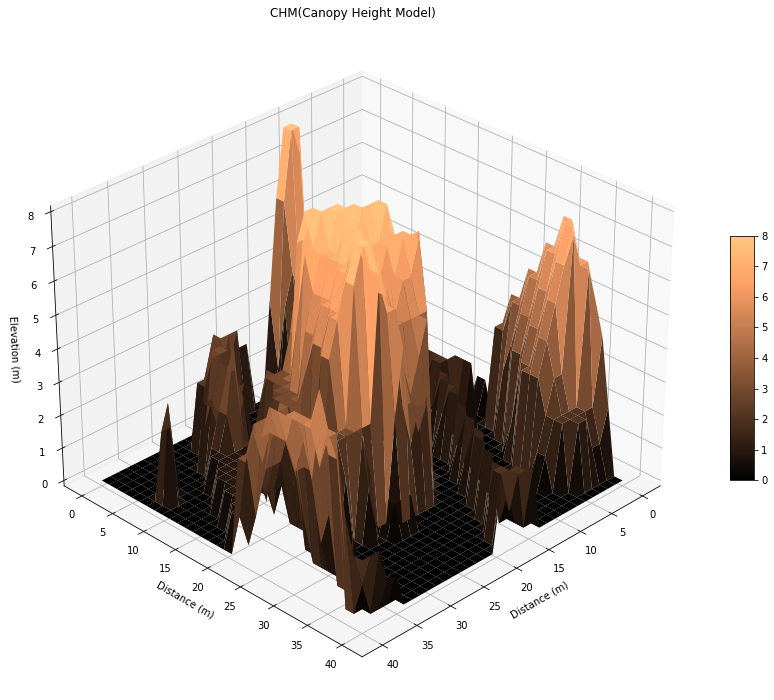

In [30]:
# Each chm is a numpy matrix
chm = imageio.imread(chm_tif)

nx,ny = chm.shape
size = 20
x = np.linspace(0, size*2, nx)
y = np.linspace(0, size*2, ny)

yv,xv = np.meshgrid(x, y)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

chm3d=ax.plot_surface(yv,xv,chm,cmap="copper",linewidth=10)
ax.set_title('CHM(Canopy Height Model)')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Distance (m)')
ax.set_zlabel('Elevation (m)')
ax.view_init(azim=45)
        
fig.colorbar(chm3d, shrink=0.3, aspect=10);
fig.savefig(address +'_3D.png', dpi=200) 
plt.show()

In [39]:
import plotly.graph_objects as go
def final_plot(ds_chm):
        fig = go.Figure(data=[go.Surface(z=ds_chm)])
        fig.update_layout(title='CHM', autosize=False, width=1000, height=900)
        fig.show()

In [40]:
final_plot(chm)